<a href="https://colab.research.google.com/github/alexandraizhevskaya/study_projects/blob/master/Audio_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A little MNIST classification tutorial

In [ ]:
! pip install torchaudio
! pip install gdown
! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch.nn as nn
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import wave
import os
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from pathlib import Path
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
! gdown https://drive.google.com/uc?id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06
! unzip /content/AudioMNIST.zip

1. We need to devide the downloaded data. There are a number of speakers that pronounce all digits several times. So, first, it is necessary to make a create a similar distribution of both speakers and numbers in train/test parts. 

In [ ]:
TRAIN_DIR = Path('/content/AudioMNIST')
all_files = list(TRAIN_DIR.rglob('*.wav'))

train_data = []
val_data = []
test_data = []
speakers = list(set(map(lambda x: x.parts[3], all_files)))
digits = list(set(map(lambda x: x.parts[4][0], all_files)))
for i in speakers:
    for j in digits:
        target_set = list(filter(lambda x: x.parts[3]==i and x.parts[4][0]==j , all_files))
        train_data.extend(target_set[:35])
        val_data.extend(target_set[35:40])
        test_data.extend(target_set[40:])

2. Then, some examples of mel spectograme (applying a logarifmic function to signal)

In [ ]:
n = np.random.randint(len(all_files))

mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80)

waveform, sample_rate = torchaudio.load(all_files[n])
mel_spectrogram = mel_spectrogramer(waveform)

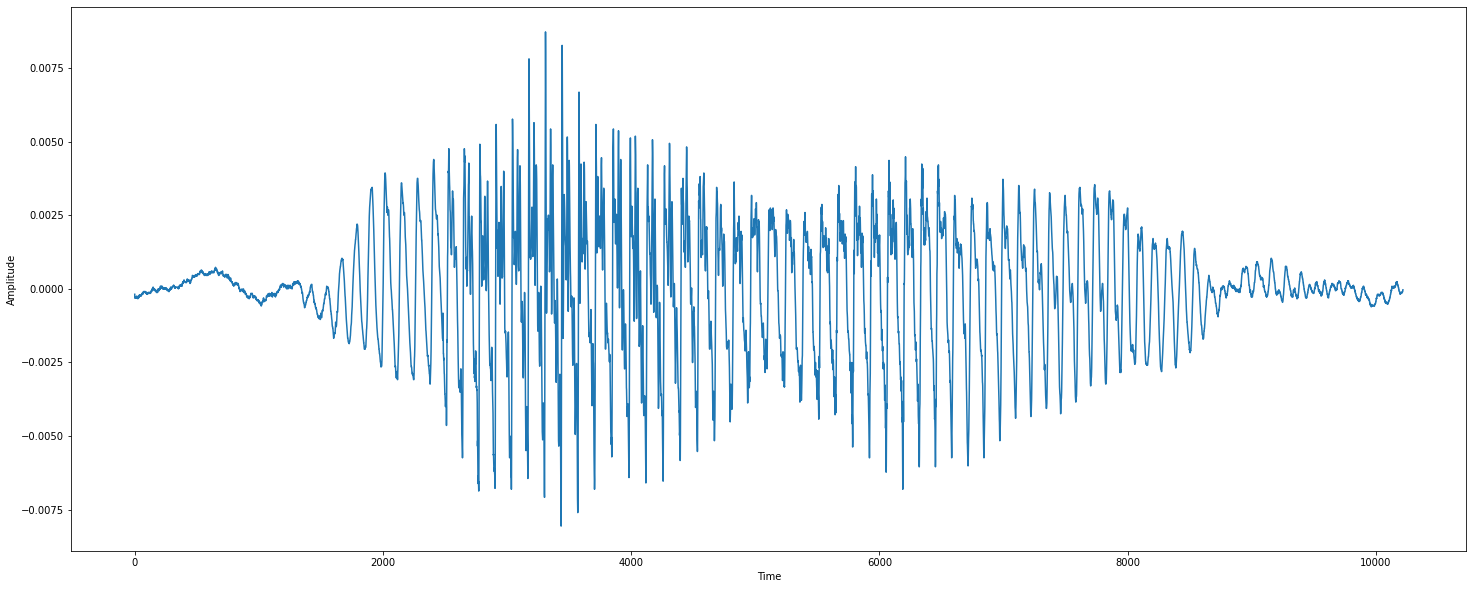

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(waveform.squeeze())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Shape of spectrogram: torch.Size([1, 80, 40])


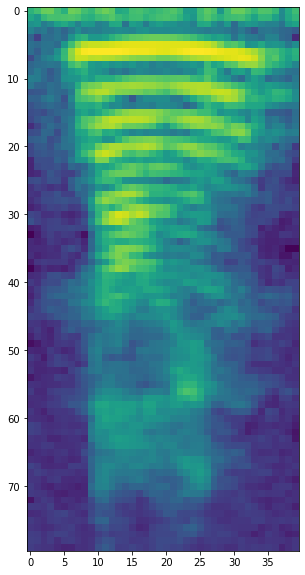

In [ ]:
print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

plt.figure(figsize=(25, 10))
plt.imshow(torch.log(mel_spectrogram.squeeze()))
plt.show()

3. We should create a dataset for the data. It allows to upload and preprocess data iteratively during the training/inference stage and, thus, optimize memory usage

In [ ]:
DATA_MODES = ['train', 'val', 'test']

In [ ]:
class DigitsDataset(Dataset):
  
    def __init__(self, files, mode):
        super().__init__()
        
        self.files = shuffle(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
              sample_rate=22050,
              n_fft=1024,
              win_length=1024,
              hop_length=256,
              f_min=0,
              f_max=8000,
              n_mels=80,
)
        
        self.labels = [int(i.parts[4][0]) for i in self.files]
            
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, sample_rate = torchaudio.load(file)
        if waveform.size()[1] > 6000:
            waveform = waveform[0, :6000]
            waveform = torch.reshape(waveform, (1, 6000))
        else:
            new = torch.zeros((1, 6000))
            new[0][0 : waveform.size()[1]] = waveform[0]
            waveform = new
        waveform = torch.reshape(waveform, (1, 6000))
        mel_spectrogram = self.mel_spectrogramer(waveform)
        mel_spectrogram = mel_spectrogram.squeeze()
        mel_spectrogram = mel_spectrogram.reshape(mel_spectrogram.size()[0], mel_spectrogram.size()[1], -1)
        
        return mel_spectrogram 
  
    def __getitem__(self, index):
        
        x = self.load_sample(self.files[index])
        x = x.permute(2, 1, 0)
        label_id = self.labels[index]
            
        y = label_id
            
        return x, y
  

In [ ]:
X_train  = DigitsDataset(train_data, mode='train')
X_val = DigitsDataset(val_data, mode='val')
X_test = DigitsDataset(test_data, mode='test')

4. Now we create a CNN-based model (it is a popular architecture, but I forgot the name)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(1920, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.cnn(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
      
        return x

model = SimpleNet(10)
model.to(device)

SimpleNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1920, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

5. define helpful functions for training and evaluating the model

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        labels = []
        for input in test_loader:
            #print(inputs)
            inputs = input[0].to(device)
            inputs = inputs.reshape(-1, inputs.size()[0], inputs.size()[1], inputs.size()[2])
            lab = input[1]
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            labels.append(lab)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1)
    preds = torch.argmax(probs, 1).numpy()
    return preds, labels

6. Finally, train!

In [ ]:
train(X_train, X_val, model, 12, 4)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 0.5782140162547986


epoch:   8%|▊         | 1/12 [00:36<06:36, 36.09s/it]


Epoch 001 train_loss: 0.5782     val_loss 0.2497 train_acc 0.8220 val_acc 0.9300
loss 0.19797363338837415


epoch:  17%|█▋        | 2/12 [01:12<06:00, 36.06s/it]


Epoch 002 train_loss: 0.1980     val_loss 0.1991 train_acc 0.9398 val_acc 0.9467
loss 0.13657748811313983


epoch:  25%|██▌       | 3/12 [01:48<05:24, 36.06s/it]


Epoch 003 train_loss: 0.1366     val_loss 0.1698 train_acc 0.9593 val_acc 0.9477
loss 0.0976804511868007


epoch:  33%|███▎      | 4/12 [02:24<04:48, 36.03s/it]


Epoch 004 train_loss: 0.0977     val_loss 0.1006 train_acc 0.9693 val_acc 0.9687
loss 0.07572560969557313


epoch:  42%|████▏     | 5/12 [03:00<04:12, 36.05s/it]


Epoch 005 train_loss: 0.0757     val_loss 0.0867 train_acc 0.9756 val_acc 0.9730
loss 0.06593843331553281


epoch:  50%|█████     | 6/12 [03:36<03:36, 36.12s/it]


Epoch 006 train_loss: 0.0659     val_loss 0.0981 train_acc 0.9796 val_acc 0.9703
loss 0.07040113016708535


epoch:  58%|█████▊    | 7/12 [04:12<03:00, 36.08s/it]


Epoch 007 train_loss: 0.0704     val_loss 0.0729 train_acc 0.9801 val_acc 0.9783
loss 0.05293334109802555


epoch:  67%|██████▋   | 8/12 [04:48<02:24, 36.07s/it]


Epoch 008 train_loss: 0.0529     val_loss 0.0777 train_acc 0.9844 val_acc 0.9810
loss 0.04141176722300199


epoch:  75%|███████▌  | 9/12 [05:24<01:48, 36.09s/it]


Epoch 009 train_loss: 0.0414     val_loss 0.1040 train_acc 0.9862 val_acc 0.9723
loss 0.035050565432065084


epoch:  83%|████████▎ | 10/12 [06:00<01:12, 36.17s/it]


Epoch 010 train_loss: 0.0351     val_loss 0.0953 train_acc 0.9878 val_acc 0.9770
loss 0.06433760731372591


epoch:  92%|█████████▏| 11/12 [06:37<00:36, 36.13s/it]


Epoch 011 train_loss: 0.0643     val_loss 0.1146 train_acc 0.9873 val_acc 0.9757
loss 0.03134158059206854


epoch: 100%|██████████| 12/12 [07:13<00:00, 36.09s/it]


Epoch 012 train_loss: 0.0313     val_loss 0.0689 train_acc 0.9900 val_acc 0.9847


[(0.5782140162547986,
  0.822,
  0.24970321073247276,
  tensor(0.9300, device='cuda:0', dtype=torch.float64)),
 (0.19797363338837415,
  0.9397619047619048,
  0.1991475075307826,
  tensor(0.9467, device='cuda:0', dtype=torch.float64)),
 (0.13657748811313983,
  0.9593333333333334,
  0.16977872896359864,
  tensor(0.9477, device='cuda:0', dtype=torch.float64)),
 (0.0976804511868007,
  0.9692857142857143,
  0.10064482310741898,
  tensor(0.9687, device='cuda:0', dtype=torch.float64)),
 (0.07572560969557313,
  0.9756190476190476,
  0.08671937260560936,
  tensor(0.9730, device='cuda:0', dtype=torch.float64)),
 (0.06593843331553281,
  0.9796190476190476,
  0.09807138350501751,
  tensor(0.9703, device='cuda:0', dtype=torch.float64)),
 (0.07040113016708535,
  0.9800952380952381,
  0.07289556530494631,
  tensor(0.9783, device='cuda:0', dtype=torch.float64)),
 (0.05293334109802555,
  0.9843809523809524,
  0.0777228636126997,
  tensor(0.9810, device='cuda:0', dtype=torch.float64)),
 (0.0414117672230

7. Oh, that's evaluation!

In [ ]:
preds, labels = predict(model_baseline, X_test)
accuracy_score(labels, preds)

0.9831666666666666

Not that bad;)